In [1]:
import os, os.path as osp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imblearn

%matplotlib inline

In [2]:
DATA_DIR = '/home/chandan/Documents/datasets/talkingdata-adtracking-fraud-detection'

In [3]:
train = pd.read_csv(osp.join(DATA_DIR, 'train_sample.csv'))
test = pd.read_csv(osp.join(DATA_DIR, 'test.csv'))

In [4]:
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


In [5]:
test.head()

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


In [6]:
# attributes
train.columns

Index([u'ip', u'app', u'device', u'os', u'channel', u'click_time',
       u'attributed_time', u'is_attributed'],
      dtype='object')

## Train

- ip: ip address of click.
   - encoding: int
   - IP address dont have a >, < ordering
   - closer IP addresses may be geographically closer
   - transform: bin it and make it categorical?
- app: app id for marketing.
    - encoding: 
- device: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
    - encoding: 
- os: os version id of user mobile phone
    - encoding: 
- channel: channel id of mobile ad publisher
- click_time: timestamp of click (UTC)
- attributed_time: if user download the app for after clicking an ad, this is the time of the app download
- is_attributed: the target that is to be predicted, indicating the app was downloaded

Note that ip, app, device, os, and channel are encoded.

## Test

- click_id: reference for making predictions
- is_attributed: not included

In [7]:
from scipy.sparse import hstack

def get_XY(df):
    '''
    df: dataframe read from CSV
    
    return:
    X: dataframe of features that can be given to model.fit
    Y: dataframe of targets
    '''
    X = df.drop('is_attributed', axis=1) # drop doesnt work inplace
    Y = df.is_attributed
    
    # remove attributed_column - dont know how to use it 
    X.drop('attributed_time', axis=1, inplace=True)
    
    ip_feature = encode_ip(X.ip)  
    os_feature = encode_os(X.os)
    clicktime_feature = encode_click_time(X.click_time)
    
    all_features = [ip_feature,
               os_feature,
               clicktime_feature,
               X.app,
               X.device,
               X.channel
            ]
    
    # make single value features shape (n, 1)
    for i in range(len(all_features)):
        print (all_features[i].shape)
        if len(all_features[i].shape) == 1:
            all_features[i] = all_features[i].reshape((-1, 1))
    
    X = hstack(all_features)
    
    return X, Y

In [8]:
# ip address - divide into 1000 bins
from sklearn.preprocessing import OneHotEncoder

def encode_ip(ip):
    num_ip_bins = 1024
    binned_ips = (ip / num_ip_bins).astype(int) 
    enc = OneHotEncoder()
    
    return enc.fit_transform(binned_ips.values.reshape((-1, 1)))

In [9]:
# convert click time to time or day, weekend indicator, day of week
from datetime import datetime

def encode_click_time(ct):
    converted = pd.to_datetime(ct, infer_datetime_format=True)
    dayofweek = converted.dt.dayofweek 
    return dayofweek

In [10]:
# hash the device ID - has too many unique values

(0, 866)


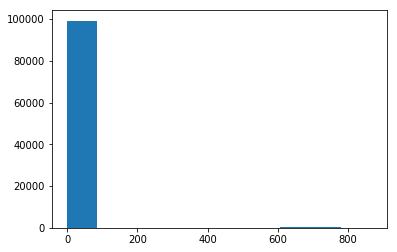

In [12]:
# OS
print(train.os.min(), train.os.max())
plt.hist(train.os, bins=10)

from sklearn.preprocessing import OneHotEncoder

def encode_os(os):
    # make categorical
    # 0-200, 600-800
    os[(os > 600) & (os < 800)] -= 400
    
    # now everything is in 0-400
    # one hot encode
    num_os_bins = 20
    binned_os = (os / num_os_bins).astype(int) 
    enc = OneHotEncoder()
    
    onehot = enc.fit_transform(binned_os.values.reshape((-1, 1)))
    
    return enc.fit_transform(binned_os.values.reshape((-1, 1)))
    

In [13]:
# prepare features and split data
from sklearn.model_selection import train_test_split

X, Y = get_XY(train)
print ('X shape: ', X.shape)
print ('Y shape: ', Y.shape)

trainX, testX, trainY, testY = train_test_split(X, Y)

print ('Train samples:', trainX.shape[0])
print ('Test samples:', testX.shape[0])

(100000, 357)
(100000, 14)
(100000,)
(100000,)
(100000,)
(100000,)
('X shape: ', (100000, 375))
('Y shape: ', (100000,))
('Train samples:', 75000)
('Test samples:', 25000)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [14]:
print(trainX.shape)

(75000, 375)


[74840   160]
(75000,)


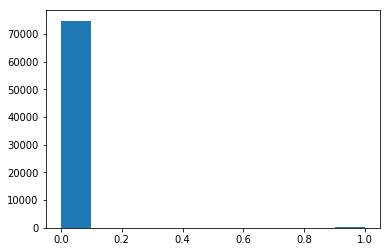

In [15]:
# labels are skewed
plt.hist(trainY)
print(np.bincount(trainY))
print(trainY.shape)

In [16]:
# over sample the 1 (fraud) class
'''
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
trainX, trainY = ros.fit_sample(trainX, trainY)
'''

'\nfrom imblearn.over_sampling import RandomOverSampler\nros = RandomOverSampler(random_state=0)\ntrainX, trainY = ros.fit_sample(trainX, trainY)\n'

[74840   160]


(array([74840.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,   160.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

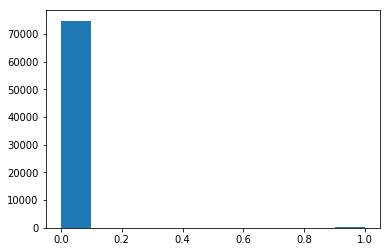

In [17]:
# distribution of resampled labels
print(np.bincount(trainY))
plt.hist(trainY)

In [18]:
# train logistic regression
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(class_weight='balanced')
model.fit(trainX, trainY)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [19]:
# evaluate
from sklearn.metrics import confusion_matrix
preds = model.predict(testX)
model.score(testX, testY)
print (confusion_matrix(testY, preds))

[[22136  2797]
 [   48    19]]


In [20]:
# AU ROC
from sklearn.metrics import roc_auc_score
print (roc_auc_score(testY, preds))

0.5857007227129901


In [13]:
# SGD classifier with partial fit